In [72]:
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

from src.DataManager import DataManager
from src.config import IMDB_CROPPED_PATH, IMBD_CROPPED_METADATA_FILENAME
from src.models.HandcraftedModel import HandcraftedModel
from src.models.Model import IMAGE_INPUT_SIZE

In [3]:

df = pd.DataFrame()

with tqdm(total=len(os.listdir('../dataset/utk/crop_part1'))) as pbar:
    for file in os.listdir('../dataset/utk/crop_part1'):
        d = {}
        d["path"] = file
        attr = file.split('_')
        d["age"] = attr[0]
        # 0 male, 1 female
        d["gender"] = attr[1]
        df = df.append(d, ignore_index=True)
        pbar.update(1)

100%|██████████| 9780/9780 [00:16<00:00, 585.87it/s]


In [4]:
df.describe()

,path,age,gender
count,9780,9780,9780
unique,9780,99,3
top,100_1_0_20170110183726390.jpg.chip.jpg,1,1
freq,1,1112,5407


In [5]:
def standardize_age(dataset, scaler):
    x = np.expand_dims(dataset['age'], -1)
    scaler.fit(x)
    new_x = scaler.transform(x)
    dataset['age'] = new_x
    return dataset


scaler = MinMaxScaler()
df = standardize_age(df, scaler)

In [6]:
df = df[:1000]
df.describe()

,age
count,1000.000000
mean,0.122523
std,0.062354
min,0.082569
25%,0.100917
50%,0.119266
75%,0.137615
max,1.000000


In [7]:
def split_dataset(dataset):
    train, test = train_test_split(dataset, test_size=0.3)
    train, validation = train_test_split(dataset, test_size=.15)
    return train, validation, test


train, validation, test = split_dataset(df)

In [8]:
X_train = []
y_train = pd.DataFrame(train[["gender", "age"]])
with tqdm(total=len(train)) as pbar:
    for _, x in train.iterrows():
        img = cv2.imread("../dataset/utk/crop_part1/" + x["path"])
        X_train.append(img)
        pbar.update(1)

X_test = []
y_test = pd.DataFrame(test[["gender", "age"]])
with tqdm(total=len(test)) as pbar:
    for _, x in test.iterrows():
        img = cv2.imread("../dataset/utk/crop_part1/" + x["path"])
        X_test.append(img)
        pbar.update(1)

X_val = []
y_val = pd.DataFrame(validation[["gender", "age"]])
with tqdm(total=len(validation)) as pbar:
    for _, x in validation.iterrows():
        img = cv2.imread("../dataset/utk/crop_part1/" + x["path"])
        X_val.append(img)
        pbar.update(1)

100%|██████████| 150/150 [00:00<00:00, 494.71it/s]


In [9]:
# EXTRACTIONS
n_sift = 150
color_hist_bins = 128
lbp_n_points = 24
lbp_radius = 3
handcrafted_model = HandcraftedModel(n_sift, color_hist_bins, lbp_n_points, lbp_radius)

df_train = handcrafted_model.extract_dataset_features(X_train, y_train)
df_val = handcrafted_model.extract_dataset_features(X_val, y_val)
df_test = handcrafted_model.extract_dataset_features(X_test, y_test)

# CLEANING FROM NANS
data_manager = DataManager(IMDB_CROPPED_PATH, IMBD_CROPPED_METADATA_FILENAME, IMAGE_INPUT_SIZE,
                           n_subset=1, normalize_images=False, normalize_age=True)
data_manager.delete_nan_columns(df_train, df_val, df_test)

Extracting dataset features ...


100%|██████████| 850/850 [09:29<00:00,  1.49it/s]
C:\Users\lucre\PycharmProjects\visual-processing-project\src\models\HandcraftedModel.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["gender"] = y["gender"].values
C:\Users\lucre\PycharmProjects\visual-processing-project\src\models\HandcraftedModel.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["age"] = y["age"].values


Extracting dataset features ...


100%|██████████| 150/150 [01:14<00:00,  2.00it/s]


Extracting dataset features ...


100%|██████████| 300/300 [02:25<00:00,  2.05it/s]


Deleted a maximum of 129 columns


In [11]:
# srotolo
df_train_new = pd.DataFrame()
for _, row in df_train.iterrows():
    d = {}
    i = 0
    for col in range(26):
        d[i] = row[col]
        i = i + 1
    for col in range(26, len(df_train.columns) - 2):
        for el in row[col]:
            d[i] = el
            i = i + 1
    df_train_new = df_train_new.append(d, ignore_index=True)

df_val_new = pd.DataFrame()
for _, row in df_val.iterrows():
    d = {}
    i = 0
    for col in range(26):
        d[i] = row[col]
        i = i + 1
    for col in range(26, len(df_val.columns) - 2):
        for el in row[col]:
            d[i] = el
            i = i + 1
    df_val_new = df_val_new.append(d, ignore_index=True)

df_test_new = pd.DataFrame()
for _, row in df_test.iterrows():
    d = {}
    i = 0
    for col in range(26):
        d[i] = row[col]
        i = i + 1
    for col in range(26, len(df_test.columns) - 2):
        for el in row[col]:
            d[i] = el
            i = i + 1
    df_test_new = df_test_new.append(d, ignore_index=True)

In [12]:
print(df_train_new.shape)
print(df_val_new.shape)
print(df_test_new.shape)

(850, 2842)
(150, 2842)
(300, 2842)


In [19]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(df_train_new, df_train["age"])

DecisionTreeRegressor(random_state=0)

1.7400000000000004
1.319090595827292
0.4366666666666674


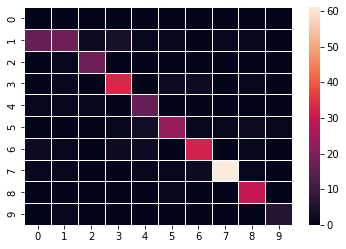

In [71]:
preds_test = regressor.predict(df_test_new)
age_test = scaler.inverse_transform([df_test["age"]])[0]
age_preds_test = scaler.inverse_transform([preds_test])[0]

print(mean_squared_error(age_test, age_preds_test))
print(math.sqrt(mean_squared_error(age_test, age_preds_test)))
print(mean_absolute_error(age_test, age_preds_test))

age_test_new = []
for a in age_test:
    if a < 80:
        age_test_new.append(math.floor(a))

age_preds_test_new = []
for a in age_preds_test:
    if a < 80:
        age_preds_test_new.append(math.floor(a))

conf_mat_test = confusion_matrix(age_test_new, age_preds_test_new)

ax = sns.heatmap(conf_mat_test, linewidth=0.5)
plt.show()

10.483333333333336
3.2377976053690163
2.5666666666666673


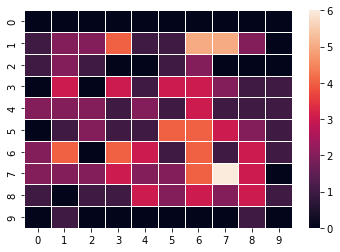

In [70]:
preds_val = regressor.predict(df_val_new)
age_val = scaler.inverse_transform([df_val["age"]])[0]
age_preds_val = scaler.inverse_transform([preds_val])[0]

print(mean_squared_error(age_val, age_preds_val))
print(math.sqrt(mean_squared_error(age_val, age_preds_val)))
print(mean_absolute_error(age_val, age_preds_val))

age_val_new = []
for a in age_val:
    age_val_new.append(math.floor(a))

age_preds_val_new = []
for a in age_preds_val:
    age_preds_val_new.append(math.floor(a))

conf_mat_val = confusion_matrix(age_val_new, age_preds_val_new)

ax = sns.heatmap(conf_mat_val, linewidth=0.5)
plt.show()